This notebook is used to parsing the movie script into different characters. The result is not used in the movie recommedation system. The main characters detected in this notebook were used as stop words when performing NLP on the whole script. 

In [2]:
%matplotlib inline
import pickle
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from copy import deepcopy
from nltk.corpus import stopwords
from collections import Counter
import string
from copy import deepcopy

In [3]:
with open('data/movie_meta_final_clean.pkl', 'rb') as f:
    movie_meta = pickle.load(f)

Parse script text:

Get stop words dict
Count the freq, get the top5, those should be the name of the main character


Make a dictionary with the Character Name or Scene Name as keys.
In the dictionary the key is the character, the value stored with the key is another dictionary with all the lines fro that character and indexed (key) by the order of the line. Ignore empty key and keys with low lines

In [4]:
sw = stopwords.words('english')

In [5]:
sw = sw + ['int', 'ext', 'cont']

In [6]:
common_words = []
with open('common_words.txt', 'r') as f:
    for line in f:
        if line.strip()!= 'bill' and line.strip()!= 'voice' and line.strip()!= 'summer' and line.strip()!='will':
            common_words.append(line.strip().lower())


In [7]:
common_words.extend(['dr', 'de', 'san', 'looks', 'going', 'dr.', 'mrs.', 'mr.', 'uh', 'huh', 'ms', 'ms.',
                     'ya', 'yah', 'hey', 'lt', 'hi', 'got', 'guys', 'gov.', 'st', 'misery', 'shark',
                    'ring', 'lama', 'lung', 'mirror', 'sir', 'says', 'buddy', 'thou', 'walks', 'st.', 'ship', 'x', 
                     'jr.', 'english', 'china', 'racer', 'j', 'raff', 'ha', 'angle'])

In [8]:
def parse_text(text):  #current working
    '''This version only extract 4 lines after the apearance of the character
    '''
    text = text.strip()
    b_tags = re.findall('<b>', text)
    if len(b_tags)<3:
        text = re.sub('<b>[\w\W]*<\/b>', '', text)
    remove_list = ['cut to:', 'continued:', 
                  'close-up:', 'med. shot:', 'close shot:', 'fade in', 'day', 'continued',
                    '(v.o.)', 'scene deleted', "cont'd", 'beat.', 'contd',
                  '(continuing)', '(v/o)']
    text = re.sub('\n\W*\n', '\n\n', text)
    text = re.sub('\W*\d+[a-zA-Z]?\. .*\n' ,'\n', text)
    text = re.sub('.*DRAFT.*', '', text)
    text = re.sub('Sc\s+\d.*', '', text)
    text = re.sub('É|é', 'e', text) 
    text = re.sub('á|ä', 'a', text)
    for word in remove_list:
        text = text.lower().replace(word, '')
    text = re.sub('http:.*?com', '', text)
    text = re.sub('http:.*?net', '', text)
    text = re.sub('.*www\..*\.(org|com).*', '', text)
    text = re.sub('.*pg[\-\.].*', '', text)
    text = re.sub('(:\W*)\n', '\n', text)
    text = re.sub('.*\d+[_\.\-\/]\d+[_\.\-\/]\d+.*', '', text) #remove date
    text = re.sub('.*\d+ \d+.*', '', text)
    text = re.sub('.*revision.*', '', text)
    #text = re.sub('.*\d+\/\d+\/\d+.*', '', text)
    #text = re.sub('.*\d+_\d+_\d+.*', '', text)
    text = re.sub('.*(int\.|ext\.|angle on|close on|high angle|high wide|exterior|interior|full shot|dissolve to|open on|shooting script|c\.u\.|long shot|med\. shot).*',
                  '\n', text)
    #text = re.sub('\n\s*\n', '\n\n', text)
    
    #words = re.findall('([a-zA-Z]+)|[a-zA-Z.]{2,}', text)
    words = re.findall('([a-zA-Z0-9&\.\-]+)', text)
    #word_bag = Counter([w.lower() for w in words if w!='.' and w!='...' and w!='..' and w!='-' and w!=])
    word_bag = Counter([w.lower() for w in words if w not in ['.', '..', '...', '-', '--', '---']])
    word_list = sorted(word_bag, key=lambda x: word_bag[x], reverse=True)
    word_list = [word for word in word_list if word not in sw]
    
    w_list = word_list[:5]

    top5 =[]
    i = 0 
    while i<len(w_list):
        if (w_list[i].strip(string.punctuation) not in common_words) and len(w_list[i])>0 and not w_list[i].isnumeric():
            top5.append(w_list[i])
        i += 1
    print(top5)
    #parse each line
    #text = re.sub(' {2,}','', text)
    #text = re.sub('\r', '', text)
    #lines = text.split('\n\n')
    #print(len(lines))
    script_dict = defaultdict(dict)
 
    for ch in top5:
        script_dict[ch] = defaultdict(str)

    lines = text.split('\n')
    key = ''
    for n, line in enumerate(lines):
        if re.search('^[^a-zA-Z]*$', line):
            key = ''
            continue
        for ch in top5:
            regex = r'\b'+re.escape(ch) + r'(\W|\b)'
            if re.search(regex, line):
                key = ch
                c = 0
                line = re.sub(regex, '', line)
                if not re.search('^[^a-zA-Z]*$', line):
                    #print(n, line, 'not empty')
                    script_dict[key][n] = line.strip('1234567890').strip()
                break
        else:
            if key and c < 8:
                script_dict[key][n] = line.strip('1234567890').strip()
                c += 1
            
    return script_dict

In [85]:
movie_to_remove=['American Outlaws Script',
 'Apollo 13 Script',
 'Dawn of the Dead Script',
 'Fletch Script',
 'Made Script',
 'Mary Poppins Script',
 'Mulan Script',
 'Neverending Story, The Script',
 'Night Time (The Poltergeist Treatment) Script',
 'Ninth Gate, The Script',
 'Omega Man Script',
 'Pokemon: Mewtwo Returns Script',
 'Rescuers Down Under, The Script',
 'Scary Movie 2 Script',
 'Training Day Script',
 'We Own the Night Script',
 'Withnail and I Script', '2001: A Space Odyssey Script', 
                 'Island, The Script', 'Game, The Script',
                'Le Diable par la Queue Script', 'Ni vu ni connu Script', 'Les Tontons Flingueurs Script', #not in English
                 'Ni vu ni connu Script', 'Un Singe en Hiver Script', #not in English
                 'Frozen Script', '9 Script',#weired letters in line
                 'Adaptation Script' , 'Ace Ventura: Pet Detective Script', 'Amelia Script', 
                 'Addams Family, The Script', #extremely huge
                 'Damned United, The Script', 'Awakenings Script',  #weired spaces between words
                 "My Mother Dreams the Satan's Disciples in New York Script", 'Road, The Script',
                 'Wind Chill Script', 'Silver Linings Playbook Script', # cannot separate pat and pat.sr
                 'Mask, The Script', 'Meet John Doe Script', 'Erik the Viking Script', 'Army of Darkness Script',
                 'Beach, The Script', 'Chasing Sleep Script', 'Heavy Metal Script', 'Highlander: Endgame Script',
                 'Never Been Kissed Script', 'Nightmare Before Christmas, The Script'
                ] 

In [126]:
movie_meta[:] = [movie for movie in movie_meta if movie['title'] not in movie_to_remove]

In [ ]:
# for movie in movie_meta:
#     movie['script_by_char'] = parse_text(movie['scripts'])
#     #print(movie['title'], movie['script_by_char'].keys())

In [154]:
i = 0
movie_meta8 = []
for movie in movie_meta[i:]:
    movie1 = {}
    print(i, movie['title'])
    movie1['script_by_char'] = parse_text(movie['scripts'])
    movie1['title'] = movie['title']
    movie_meta8.append(movie1)
    i+=1

0 10 Things I Hate About You Script
['kat', 'patrick', 'bianca', 'cameron', 'michael']
1 12 Script
['tony', 'allen', 'marie-noel']
2 12 and Holding Script
['jacob', 'malee', 'leonard', 'gus', 'grace']
3 12 Monkeys Script
['cole', 'railly', 'jeffrey', 'voice']
4 12 Years a Slave Script
['solomon', 'epps', 'slaves', 'patsey']
5 127 Hours Script
['aron']
6 1492: Conquest of Paradise Script
['columbus', 'fernando', 'sanchez', 'utapan']
7 15 Minutes Script
['jordy', 'emil', 'eddie', 'oleg', 'daphne']
8 17 Again Script
['mike', 'ed', 'alex', 'scarlet', 'maggie']
9 187 Script
['trevor', 'ellen', 'cesar', 'rita']
10 2012 Script
['jackson', 'adrian', 'kate', 'anheuser', 'gordon']
11 30 Minutes or Less Script
['dwayne', 'chet', 'jay']
12 42 Script
['jack', 'rickey', 'rachel', 'smith']
13 44 Inch Chest Script
['colin', 'archie', 'meredith', 'mal', 'omp']
14 48 Hrs. Script
['cates', 'hammond', 'ganz', 'luther', 'elaine']
15 50-50 Script
['adam', 'seth', 'rachel', 'katie', 'edith']
16 500 Days of S

['bean', 'david', 'grierson', 'alison', 'bernie']
126 Beasts of the Southern Wild Script
['hushpuppy', 'wink', 'bathsheba']
127 Beavis and Butt-head Do America Script
['beavis', 'butt-head', 'b&b']
128 Beginners Script
['oliver', 'hal', 'anna', 'arthur', 'andy']
129 Being Human Script
['hector', 'lucinnius', 'beatrice', 'bobby']
130 Being John Malkovich Script
['craig', 'malkovich', 'lotte', 'maxine', 'lester']
131 Being There Script
['eve', 'rand']
132 Believer, The Script
['danny', 'carla', 'curtis', 'kyle']
133 Belle Script
['dido', 'mansfield', 'lady', 'lord', 'john']
134 Beloved Script
['sethe', 'paul', 'denver', 'beloved']
135 Best Exotic Marigold Hotel, The Script
['evelyn', 'sonny', 'douglas', 'graham', 'muriel']
136 Big Script
['josh', 'susan', 'billy', 'paul']
137 Big Blue, The Script
['jacques', 'enzo', 'johana', 'roberto']
138 Big Eyes Script
['walter', 'margaret', 'jane', 'keane']
139 Big Fish Script
['edward', 'sandra', 'josephine', 'jenny']
140 Big Lebowski, The Script
[

['coraline', 'wybie', 'cat']
249 Coriolanus Script
['coriolanus', 'menenius', 'aufidius', 'martius', 'volumnia']
250 Cowboys & Aliens Script
['jake', 'ella', 'dolarhyde', 'doc']
251 Cradle 2 the Grave Script
['fait', 'su', 'daria', 'ling', 'tommy']
252 Crank Script
['chev', 'eve', 'verona']
253 Crash Script
['james', 'vaughan', 'catherine', 'helen']
254 Crazy, Stupid, Love Script
['cal', 'jacob', 'tracy', 'robbie', 'jessica']
255 Crazylove Script
['letty', 'michael', 'ruth', 'paul']
256 Creation Script
['darwin', 'emma', 'annie', 'innes']
257 Crime Spree Script
['sami', 'daniel', 'zammito', 'marcel', 'raymond']
258 Croods, The Script
['grug', 'eep', 'thunk', 'croods']
259 Crouching Tiger, Hidden Dragon Script
['jen', 'yu', 'li', 'lo', 'fox']
260 Croupier Script
['jack', 'jani', 'reynolds', 'marion', 'voice']
261 Crow Salvation, The Script
['alex', 'erin', 'captain', 'madden', 'lauren']
262 Crow, The Script
['eric', 'albrecht', 'elly', 'lao']
263 Crow: City of Angels, The Script
['ashe'

['forrest', 'jenny', 'dan']
371 Four Feathers Script
['harry', 'durrance', 'trench', 'ethne', 'willoughby']
372 Four Rooms Script
['ted', 'sigfried', 'chester', 'sarah']
373 Foxcatcher Script
['mark', 'du', 'pont', 'dave']
374 Fracture Script
['willy', 'crawford', 'nunally', 'nikki']
375 Frances Script
['frances', 'harry', 'lillian']
376 Frankenstein Script
['victor', 'creature', 'elizabeth', 'henry', 'walton']
377 Frankenweenie Script
['victor', 'sparky', 'mom', 'toshiaki', 'bob']
378 Freaked Script
['rick', 'elijah', 'julie', 'ernie', 'stuey']
379 Freddy vs. Jason Script
['meagan', 'erwin', 'jason', 'stormie', 'freddy']
380 French Connection, The Script
['doyle', 'russo', 'charnier']
381 Frequency Script
['frank', 'john', 'satch', 'shepard', 'julia']
382 Friday the 13th Script
['alice', 'bill', 'jack', 'marcie', 'ned']
383 Friday the 13th Part VIII: Jason Takes Manhattan Script
['rennie', 'sean', 'jason', 'mcculloch']
384 Fright Night Script
['charlie', 'amy', 'jerry', 'ed', 'peter']

['ryan', 'ramius', 'mancuso', 'jones']
494 I Am Number Four Script
['john', 'henri', 'sarah', 'sam', 'mark']
495 I am Sam Script
['sam', 'lucy', 'rita', 'turner']
496 I Love You Phillip Morris Script
['steven', 'phillip', 'debbie', 'kemple']
497 I Spit on Your Grave Script
['jennifer', 'johnny', 'storch', 'sheriff', 'stanley']
498 I Still Know What You Did Last Summer Script
['julie', 'karla', 'tyrell', 'ray', 'nancy']
499 I'll Do Anything Script
['matt', 'jeannie', 'burke', 'cathy', 'nan']
500 I, Robot Script
['spooner', 'calvin', 'robot', 'spooner.', 'sonny']
501 Ice Storm, The Script
['ben', 'elena', 'wendy', 'paul', 'sandy']
502 Ides of March, The Script
['stephen', 'molly', 'paul', 'morris', 'gov.']
503 Imaginarium of Doctor Parnassus, The Script
['parnassus', 'valentina', 'tony', 'anton']
504 In the Bedroom Script
['matt', 'ruth', 'willis', 'natalie', 'frank']
505 In the Loop Script
['simon', 'toby', 'malcolm', 'karen', 'judy']
506 Inception Script
['cobb', 'arthur', 'ariadne', '

['clay', 'jensen', 'roque', 'pooch', 'max']
614 Lost Highway Script
['pete', 'fred', 'alice', 'renee']
615 Lost Horizon Script
['conway', 'george', 'barnard', 'chang', 'lovett']
616 Lost in Space Script
['smith', 'john', 'penny', 'maureen']
617 Lost in Translation Script
['bob', 'charlotte', 'john', 'japanese']
618 Love and Basketball Script
['monica', 'quincy', 'camille', 'zeke']
619 Machete Script
['machete', 'elektra', 'benz', 'rnewman', 'endeavor']
620 Machine Gun Preacher Script
['sam', 'deng', 'lynn', 'donnie']
621 Mad Max 2: The Road Warrior Script
['max', 'captain', 'wez', 'pappagallo']
622 Magnolia Script
['jimmy', 'jim', 'kurring', 'frank']
623 Majestic, The (The Bijou) Script
['luke', 'pete', 'harry', 'adele']
624 Major League Script
['taylor', 'vaughn', 'brown', 'hayes', 'lynn']
625 Malcolm X Script
['malcolm', 'bembry']
626 Malibu's Most Wanted Script
['brad', 'sean', 'shondra', 'bill', 'pj']
627 Man in the Iron Mask Script
['artagnan', 'aramis', 'athos', 'louis', 'porthos

['clive', 'graham', 'paul', 'ruth', 'zoil']
735 Pearl Harbor Script
['rafe', 'danny', 'evelyn']
736 Peeping Tom Script
['mark', 'helen']
737 Peggy Sue Got Married Script
['peggy', 'charlie', 'richard', 'kelcher', 'carol']
738 Perfect Creature Script
['lilly', 'silus', 'edgar', 'jones']
739 Perfect World, A Script
['butch', 'phillip', 'sally', 'adler']
740 Perks of Being a Wallflower, The Script
['charlie', 'sam', 'patrick', 'mary', 'elizabeth']
741 Pet Sematary Script
['louis', 'jud', 'rachel', 'ellie']
742 Pet Sematary II Script
['geoff', 'chase', 'drew', 'gus', 'clyde']
743 Petulia Script
['archie', 'petulia', 'david', 'polo']
744 Philadelphia Script
['andrew', 'joe', 'wheeler', 'miguel', 'cont.']
745 Phone Booth Script
['stu', 'voice', 'ramey', 'booth']
746 Pi Script
['max', 'lenny', 'sol', 'meyer', 'marcy']
747 Pianist, The Script
['szpilman', 'german', 'henryk']
748 Piano, The Script
['ada', 'baines', 'stewart', 'flora', 'piano']
749 Pineapple Express Script
['dale', 'saul', 'ted'

['jack', 'wendy', 'danny', 'halloran']
857 Shipping News, The Script
['quoyle', 'wavey', 'bunny', 'agnis', 'jack']
858 Shivers Script
['luc', 'tudor', 'janine', 'rollo']
859 Shrek Script
['shrek', 'donkey', 'fiona', 'farquaad']
860 Shrek the Third Script
['shrek', 'donkey', 'charming', 'prince', 'puss']
861 Sideways Script
['miles', 'jack', 'maya', 'stephanie']
862 Siege, The Script
['hub', 'elise', 'frank', 'devereaux', 'samir']
863 Signs Script
['graham', 'merrill', 'morgan', 'bo']
864 Silence of the Lambs Script
['clarice', 'lecter', 'crawford']
865 Silver Bullet Script
['marty', 'uncle', 'jane', 'al']
866 Simone Script
['viktor', 'simone', 'elaine', 'lainey', 'max']
867 Single White Female Script
['allison', 'hedra', 'sam', 'voice']
868 Sister Act Script
['christy', 'mary', 'superior', 'eddie']
869 Six Degrees of Separation Script
['ouisa', 'flan', 'paul', 'elizabeth']
870 Sixth Sense, The Script
['cole', 'malcolm', 'lynn', 'anna']
871 Sleepless in Seattle Script
['annie', 'sam', '

['woody', 'buzz', 'andy', 'sid', 'toys']
979 Traffic Script
['robert', 'helena', 'caroline', 'gordon', 'javier']
980 Trainspotting Script
['renton', 'begbie', 'sick', 'spud']
981 Transformers: The Movie Script
['rod', 'kup', 'daniel', 'ultra']
982 Tremors Script
['val', 'earl', 'rhonda', 'burt']
983 Tristan and Isolde Script
['tristan', 'isolde', 'marke', 'king', 'wictred']
984 TRON Script
['flynn', 'tron', 'sark', 'yori']
985 TRON: Legacy Script
['rush', 'mega', 'krod', 'flynn', 'plexor']
986 Tropic Thunder Script
['speedman', 'sandusky', 'lazarus', 'damien']
987 True Grit Script
['mattie', 'rooster', 'leboeuf', 'chaney']
988 True Lies Script
['harry', 'helen', 'gib', 'simon', 'malik']
989 True Romance Script
['clarence', 'alabama', 'dick']
990 Truman Show, The Script
['truman', 'christof', 'meryl', 'marlon']
991 Twilight Script
['bella', 'edward', 'charlie', 'cullen']
992 Twilight: New Moon Script
['bella', 'edward', 'jacob', 'alice', 'charlie']
993 Twin Peaks Script
['laura', 'desmo

In [1]:
whos

Interactive namespace is empty.


In [14]:
for movie in movie_meta:
    if movie['title'] == 'Mask, The Script':
        text = movie['scripts']

In [15]:
script_by_char = parse_text(text)

['stanley', 'mask', 'dorian', 'tina', 'kellaway']


In [16]:
%store script_by_char

Stored 'script_by_char' (defaultdict)


In [137]:
movie_meta[760]['title']

'Precious Script'

In [105]:
movie_meta1[420]['title'] = parse_text(movie_meta[420]['scripts'])

'Godfather Part III, The Script'

In [151]:
movie1 = {}
movie1['title'] = movie_meta[760]['title']
movie1['script_by_char']= parse_text(movie_meta[760]['scripts'])
movie_meta1[760] = deepcopy(movie1)

['precious', 'rain', 'mary']


In [119]:
movie1 = {}
movie1['title'] = movie_meta[420]['title']
movie1['script_by_char']= parse_text(movie_meta[420]['scripts'])
movie_meta1[420] = deepcopy(movie1)

['tony', 'elizabeth']


In [132]:
movie_meta1[365]

{'script_by_char': defaultdict(dict,
             {'dory': defaultdict(str,
                          {706: 'look out!',
                           715: "ohh. oh, oh. sorry! i didn't see you. sir, are you okay?",
                           721: "there, there. it's all right.",
                           727: "it'll be okay.",
                           733: "hey, i've seen a boat.",
                           739: 'it passed by not too long ago.',
                           745: "hi. i'm",
                           751: 'oh, oh, oh! it-it went, um, this way! and it went this way! follow me!',
                           760: 'no problem.',
                           766: 'will you quit it?',
                           772: "i'm trying to swim here. what, ocean ain't big enough for you?",
                           778: "you got a problem, buddy? huh? huh? do 'ya? do 'ya? do 'ya? you want a piece of me? yeah,",
                           779: "oooh, i'm scared now. whaat!?",
           

In [152]:
with open('data/movie_meta_top5_4lines_0820.pkl', 'wb') as f:
    pickle.dump(movie_meta1, f)

Try to figure out how many characters to analyze for each play.

Larry Crowne Script dict_keys(['larry', 'crowne', 'mercedes', 'tainot', 'talia'])
Limitless Script dict_keys(['eddie', 'v.0.', 'van', 'loon', 'lindy'])
Pirates of the Caribbean: Dead Man's Chest Script dict_keys(['jack', 'sparrow', 'elizabeth', 'turner', 'gibbs'])
Things My Father Never Taught Me, The Script dict_keys(['melvin', 'mike', 'mary', 'molly'])


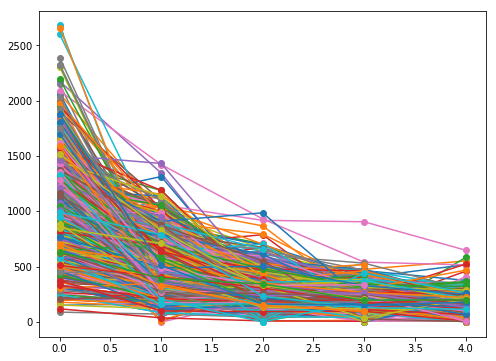

In [100]:
plt.figure(figsize=(8,6))
for movie in movie_meta1:
    characters_line = [len(x) for x in movie['script_by_char'].values()]
    #print(movie['title'])
    if len(characters_line)>3 and characters_line[1]<45:
        print(movie['title'], movie['script_by_char'].keys())
    plt.plot(range(len(characters_line)), characters_line, linestyle='-', marker='o')